In [92]:
# Import needed libraries
import sys
import os
from PIL import Image
#import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import ast
import glob

import logging
logging.basicConfig(format='%(asctime)s %(message)s')


TILE_SIZE = 256
NUM_TILES = 2

In [186]:
MY_HOME = '/home/operador/saturdays-ai/PAIthology'

LABELS_FILE = f'{MY_HOME}/src/Labels.xlsx'
IMAGES_DIR = f'{MY_HOME}/dataset/annotated_images'
TILES_DIR = f'{MY_HOME}/dataset/tiles'

os.makedirs(TILES_DIR, exist_ok=True)
os.makedirs(os.path.join(TILES_DIR,'annotations'), exist_ok=True)
os.makedirs(os.path.join(TILES_DIR,'images'), exist_ok=True)

In [120]:
# Keep only mitosis cells
labels = pd.read_excel(LABELS_FILE, dtype={"MPoint": object})
labels_mitosis = labels[labels['Mitosis']]

In [121]:
labels_mitosis.head()

,name,Combinacion,Image,Mitosis,SubImage,MPoint
0,A03_00Aa_mitosis,A03_00Aa,A03,True,1,"[[1094.0, 1223.0, 0.8]]"
2,A03_00Ab_mitosis,A03_00Ab,A03,True,1,"[[476.0, 394.0, 0.65]]"
4,A03_00Ac_mitosis,A03_00Ac,A03,True,1,"[[289.0, 1316.0, 0.65]]"
6,A03_00Ad_mitosis,A03_00Ad,A03,True,3,"[[1420.0, 199.0, 1.0], [200.0, 1190.0, 0.8], [..."
7,A03_00Ba_mitosis,A03_00Ba,A03,True,1,"[[660.0, 248.0, 0.65]]"


In [122]:
# This could be a namedtuple
class Record:
    """Class which gathers information of the position and confidence of a cell."""
    def __init__(self, y: int, x: int, confidence: float):
        # ATTENTION, Label.xlsx ARE WITH THE COORDINATES TRANSPOSED. THIS HAS BEEN CHANGED TO THAT

        self.x = x
        self.y = y
        self.confidence = confidence
        
    def generate_bndbox(self):
        bndbox_size = 30
        return (
            int(self.x - bndbox_size/2), int(self.x + bndbox_size/2),
            int(self.y - bndbox_size/2), int(self.y + bndbox_size/2)
        )


class Tile:
    """Class of all sub-frames and the specific position of mitotic cells in them."""
    def __init__(self, image, records=None):
        self.image = image
        self.records = records or []
    
    def update_records(self,record):
        self.records += [record]

In [123]:
sys.path.append(f"{MY_HOME}/src")
from xml_tools import create_base_xml, create_object_xml


class Frame:
    """Class containg all the information gathered of an specific frame and its
    mitotic and not mitotic tiles."""
    def __init__(self, path, cells, tile_size, num_tiles=10, path_annotations=None):
        self.path = path
        self.filename = os.path.basename(path)
        self.frame = cv2.imread(path)
        self.tile_size = tile_size
        self.num_tiles = num_tiles
        self.cells = cells
        self.tiles_mitosis = []
        self.tiles_not_mitosis = []
        self.records = []
        self.path_annotations = path_annotations
        self.frame_mask = []
        self.frame_mask_per_record = []
        
    def get_records(self):
        self.records = [Record(*cell) for cell in self.cells]
        print(f'Got records for {self.filename}')   
        
    def create_mask(self):
        '''Generate a mask of ones around the mitosis point'''
        mask = np.zeros(self.frame.shape[:2], np.uint8)
        for record in self.records:
            mask_per_record = np.zeros(self.frame.shape[:2], np.uint8)
            # This could use floor and ceiling to also work with odd tile sizes
            mask[int(record.x-(self.tile_size/2)):int(record.x+(self.tile_size/2)),
                 int(record.y-(self.tile_size/2)):int(record.y+(self.tile_size/2))] = 1
            
            mask_per_record[int(record.x-(self.tile_size/2)):int(record.x+(self.tile_size/2)),
                 int(record.y-(self.tile_size/2)):int(record.y+(self.tile_size/2))] = 1
            
            self.frame_mask_per_record.append(mask_per_record)
        self.frame_mask = mask
        print(f'Generated mask for {self.filename}')

    def get_all_tiles(self):
        tile_generator = TileGenerator(self, self.tile_size, self.num_tiles)
        self.tiles_mitosis = tile_generator.generate_real_positive_tiles()
        self.tiles_not_mitosis = tile_generator.generate_real_negative_tiles()
        
    def create_annotations(self):
        delta = 15
        count = 0 # enum
        for tile_mitosis in self.tiles_mitosis:
            tile_filename_base = f"{self.filename.replace('.tiff','')}_mitosis_{count}"
            tree = create_base_xml(self.path, tile_mitosis, f"{tile_filename_base}.jpg")
            
            tree.write(os.path.join(self.path_annotations,'annotations',f"{tile_filename_base}.xml"))
            cv2.imwrite(os.path.join(self.path_annotations,'images',f"{tile_filename_base}.jpg"), tile_mitosis.image)
            count += 1
        count = 0
        for tile_not_mitosis in self.tiles_not_mitosis:
            tile_filename_base = f"{self.filename.replace('.tiff','')}_not_mitosis_{count}"
            tree = create_base_xml(self.path, tile_not_mitosis, f"{tile_filename_base}.jpg")
            
            tree.write(os.path.join(self.path_annotations,'annotations',f"{tile_filename_base}.xml"))
            cv2.imwrite(os.path.join(self.path_annotations,'images',f"{tile_filename_base}.jpg"), tile_not_mitosis.image)
            count += 1

In [ ]:
import random
from matplotlib import pyplot as plt

class TileGenerator:
    def __init__(self, frame, tile_size, num_tiles):
        self.tile_size = tile_size
        self.num_tiles = num_tiles
        self.frame = frame
        self.image_frame = np.array(frame.frame)
        self.mitotic_coordinates = frame.records
        self.centroid_limits = self.get_centroid_limits()
        self.possible_negative_centroids = self.get_possible_negative_centroids()
        self.possible_positive_centroids = self.get_possible_positive_centroids()
        
    def get_possible_negative_centroids(self):
        # ATTENTION, Label.xlsx ARE WITH THE COORDINATES TRANSPOSED. THIS HAS BEEN CHANGED TO THAT
        return [coords for coords in zip(*np.where(self.frame.frame_mask == 0)) if self.check_record_presence_in_boundaries(Record(*reversed(coords), 0), self.centroid_limits)]
    
    def get_possible_positive_centroids(self):
        # ATTENTION, Label.xlsx ARE WITH THE COORDINATES TRANSPOSED. THIS HAS BEEN CHANGED TO THAT
        return [coords for coords in zip(*np.where(self.frame.frame_mask == 1)) if self.check_record_presence_in_boundaries(Record(*reversed(coords), 1), self.centroid_limits)]
        
    def get_random_negative_tile_centroid(self):
        return random.choice(self.possible_negative_centroids)
        
    def get_random_positive_tile_centroid(self):
        return random.choice(self.possible_positive_centroids)
    
    def get_centroid_limits(self):
        limits_random_centroid_x = (
            int(self.tile_size/2), # min limit
            int(frame.frame.shape[0] - self.tile_size/2)  # max limit
        )

        limits_random_centroid_y = (
            int(self.tile_size/2), # min limit
            int(frame.frame.shape[1] - self.tile_size/2)  # max limit
        )

        return limits_random_centroid_x, limits_random_centroid_y
    
    def get_boundaries_tile(self, centroid):
        return tuple(
            (int(centroid_coord - self.tile_size/2), int(centroid_coord + self.tile_size/2)) for centroid_coord in centroid
        )
    
    def check_record_presence_in_boundaries(self, record, boundaries):
        return (boundaries[0][0] <= record.x <= boundaries[0][1]) and \
               (boundaries[1][0] <= record.y <= boundaries[1][1])
    
    def frame_record_to_tile_record(self, x_min_tile : int, y_min_tile : int, record: Record) -> Record:
        x_tile = record.x - x_min_tile
        y_tile = record.y - y_min_tile    
        return Record(x_tile, y_tile, record.confidence)
    
    def generate_real_negative_tiles(self):
        negative_tiles_centroids = [self.get_random_negative_tile_centroid() for _ in range(self.num_tiles)]
        boundaries_negative_tiles = [self.get_boundaries_tile(cent) for cent in negative_tiles_centroids]
        negative_tiles_images = [self.image_frame[boundaries[0][0]:boundaries[0][1],
            boundaries[1][0]:boundaries[1][1]] for boundaries in boundaries_negative_tiles]
        negative_tiles_records = [
            [self.frame_record_to_tile_record(boundaries[0][0], boundaries[1][0], record) 
                 for record in self.mitotic_coordinates
                 if self.check_record_presence_in_boundaries(record, boundaries)
            ]
            for boundaries in boundaries_negative_tiles
        ]
        return [Tile(image, records) for image, records in zip(negative_tiles_images, negative_tiles_records)]
    
    def generate_real_positive_tiles(self):
        # Get centroids for tiles
        try:
            positive_tiles_centroids = [self.get_random_positive_tile_centroid() for _ in range(self.num_tiles)]
        except IndexError:
            print(self.possible_positive_centroids)
            print(self.centroid_limits)
        print(self.mitotic_coordinates[0].__dict__)
        
        # Get tiles' boundaries
        boundaries_positive_tiles = [self.get_boundaries_tile(cent) for cent in positive_tiles_centroids]
        print(boundaries_positive_tiles)
        
        for boundaries in boundaries_positive_tiles:
            for record in self.mitotic_coordinates:
                print(self.check_record_presence_in_boundaries(record, boundaries))
        
        # Get tiles' images
        positive_tiles_images = [self.image_frame[boundaries[0][0]:boundaries[0][1],
            boundaries[1][0]:boundaries[1][1]] for boundaries in boundaries_positive_tiles]
        
        # Get records in tiles
        positive_tiles_records = [
            [self.frame_record_to_tile_record(boundaries[0][0], boundaries[1][0], record) 
                 for record in self.mitotic_coordinates
                 if self.check_record_presence_in_boundaries(record, boundaries)
            ]
            for boundaries in boundaries_positive_tiles
        ]
        
        print(positive_tiles_records)
        
        # Show tiles within frame
        mask = np.zeros(self.frame.frame.shape[:2], np.uint8)
        for boundaries in boundaries_positive_tiles:
            mask[boundaries[0][0]:boundaries[0][1],
            boundaries[1][0]:boundaries[1][1]] = 1
        plt.imshow(cv2.bitwise_and(self.frame.frame,self.frame.frame,mask = mask))
        
        # Return tiles
        return [Tile(image, records) for image, records in zip(positive_tiles_images, positive_tiles_records)]


Interpreting A03_00Aa.tiff
Got records for A03_00Aa.tiff
Generated mask for A03_00Aa.tiff
{'x': 1223.0, 'y': 1094.0, 'confidence': 0.8}
[((1027, 1283), (955, 1211)), ((1063, 1319), (967, 1223))]
True
True
[[<__main__.Record object at 0x7f0afba33d90>], [<__main__.Record object at 0x7f0b2c8c0610>]]
Interpreting A03_00Ab.tiff
Got records for A03_00Ab.tiff
Generated mask for A03_00Ab.tiff
{'x': 394.0, 'y': 476.0, 'confidence': 0.65}
[((142, 398), (288, 544)), ((383, 639), (246, 502))]
True
True
[[<__main__.Record object at 0x7f0afbb7eb20>], [<__main__.Record object at 0x7f0afbb7e160>]]
Interpreting A03_00Ac.tiff
Got records for A03_00Ac.tiff
Generated mask for A03_00Ac.tiff
{'x': 1316.0, 'y': 289.0, 'confidence': 0.65}
[((1087, 1343), (117, 373)), ((1078, 1334), (190, 446))]
True
True
[[<__main__.Record object at 0x7f0afbb53160>], [<__main__.Record object at 0x7f0afbb53130>]]
Interpreting A03_00Ad.tiff
Got records for A03_00Ad.tiff
Generated mask for A03_00Ad.tiff
{'x': 199.0, 'y': 1420.0,

{'x': 1054.0, 'y': 1236.0, 'confidence': 0.65}
[((1044, 1300), (1061, 1317)), ((1037, 1293), (1101, 1357))]
True
True
[[<__main__.Record object at 0x7f0b2a56e9a0>], [<__main__.Record object at 0x7f0b2a56e0d0>]]
Interpreting A03_02Cd.tiff
Got records for A03_02Cd.tiff
Generated mask for A03_02Cd.tiff
{'x': 994.0, 'y': 1379.0, 'confidence': 1.0}
[((750, 1006), (1184, 1440)), ((755, 1011), (1228, 1484))]
True
True
[[<__main__.Record object at 0x7f0b2a56e790>], [<__main__.Record object at 0x7f0b2a56e730>]]
Interpreting A03_02Da.tiff
Got records for A03_02Da.tiff
Generated mask for A03_02Da.tiff
{'x': 887.0, 'y': 789.0, 'confidence': 0.65}
[((864, 1120), (719, 975)), ((455, 711), (592, 848))]
True
False
False
False
True
False
[[<__main__.Record object at 0x7f0b2a4c2f70>], [<__main__.Record object at 0x7f0b2a4c2fa0>]]
Interpreting A03_02Dc.tiff
Got records for A03_02Dc.tiff
Generated mask for A03_02Dc.tiff
[]
((128, 1248), (128, 1411))
{'x': 90.0, 'y': 1040.0, 'confidence': 0.65}


UnboundLocalError: local variable 'positive_tiles_centroids' referenced before assignment

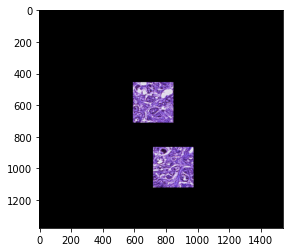

In [173]:
'''Run data augmentation 
 --> for every mitotic point we create 
 - 10 images containing that cell and
 - 10 not containing any
 '''
for i, row in labels_mitosis.iterrows():
    filename = f'{row["Combinacion"]}.tiff'
    #filename = f'{row["Combinacion"]}_mitosis.jpg'
    path_image = glob.glob(os.path.join(IMAGES_DIR,'x40', filename))
    #path_image = glob.glob(os.path.join(IMAGES_DIR, filename))
    if os.path.exists(path_image[0]):
        print(f"Interpreting {filename}")
        #if filename == 'A03_02Cd.tiff':
        cells = row["MPoint"]
        cells = ast.literal_eval(cells)
        frame = Frame(path=path_image[0],
                      cells=cells,
                      tile_size=TILE_SIZE,
                      num_tiles=NUM_TILES,
                      path_annotations=TILES_DIR)

        frame.get_records()
        frame.create_mask()
        frame.get_all_tiles()
        frame.create_annotations()


In [189]:
for i, row in labels_mitosis.iterrows():
    filename = f'{row["Combinacion"]}_mitosis.jpg'
    #path_image = glob.glob(os.path.join(IMAGES_DIR,'*','x40', filename))
    path_image = glob.glob(os.path.join(IMAGES_DIR, filename))
    break

In [190]:
filename, path_image

('A03_00Aa_mitosis.jpg',
 ['/home/operador/saturdays-ai/PAIthology/dataset/annotated_images/A03_00Aa_mitosis.jpg'])

In [147]:
f_name = f'{row["Combinacion"]}_mitosis.jpg'
p_image = glob.glob(os.path.join(f'{MY_HOME}/dataset/annotated_images', f_name))

In [148]:
p_image

['/home/operador/saturdays-ai/PAIthology/dataset/annotated_images/A03_02Cd_mitosis.jpg']

In [149]:
os.path.exists(path_image[0])

True

In [191]:
cells = row["MPoint"]
cells = ast.literal_eval(cells)
cells

[[1094.0, 1223.0, 0.8]]

In [192]:
frame = Frame(path=path_image[0],
                      cells=cells,
                      tile_size=TILE_SIZE,
                      num_tiles=NUM_TILES,
                      path_annotations=TILES_DIR)

In [193]:
frame.get_records()

Got records for A03_00Aa_mitosis.jpg


In [194]:
# Cannot handle records whose location is less than the border
frame.records[0].__dict__

{'x': 1223.0, 'y': 1094.0, 'confidence': 0.8}

In [195]:
frame.create_mask()

Generated mask for A03_00Aa_mitosis.jpg


In [196]:
frame.frame_mask.sum()

65536

In [197]:
frame.frame.shape

(1376, 1539, 3)

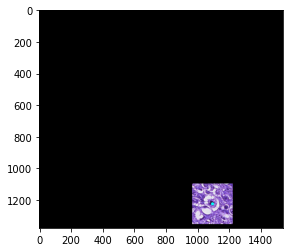

In [198]:
plt.imshow(cv2.bitwise_and(frame.frame, frame.frame, mask = frame.frame_mask))

In [158]:
frame.frame.shape

(1376, 1539, 3)

{'x': 1223.0, 'y': 1094.0, 'confidence': 0.8}
[((967, 1223), (1070, 1326)), ((1054, 1310), (949, 1205))]
True
True
[[<__main__.Record object at 0x7f0b2a65e9d0>], [<__main__.Record object at 0x7f0b2a65e5b0>]]


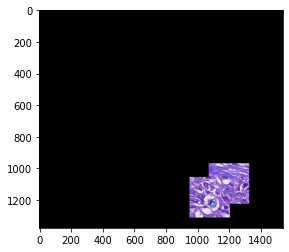

In [201]:
frame.get_all_tiles()

In [160]:
tg = TileGenerator(frame, frame.tile_size, frame.num_tiles)
tg.centroid_limits

((128, 1248), (128, 1411))

In [163]:
poss = [coords for coords in zip(*np.where(tg.frame.frame_mask == 1))]

In [167]:
tg.check_record_presence_in_boundaries(Record(*poss[0], 1), tg.centroid_limits)

False

In [169]:
poss[0]

(866, 1251)

In [170]:
Record(*reversed(poss[0]), 1).__dict__

{'x': 866, 'y': 1251, 'confidence': 1}

In [165]:
any(tg.check_record_presence_in_boundaries(Record(*coords, 1), tg.centroid_limits) for coords in poss)

False

In [59]:
frame.tiles_mitosis[1].__dict__

{'image': array([[[231, 231, 243],
         [232, 234, 245],
         [230, 235, 244],
         ...,
         [166, 122, 221],
         [182, 138, 237],
         [163, 119, 218]],
 
        [[230, 231, 241],
         [229, 231, 242],
         [228, 230, 241],
         ...,
         [183, 146, 238],
         [204, 168, 255],
         [203, 168, 255]],
 
        [[229, 228, 238],
         [227, 227, 239],
         [226, 226, 240],
         ...,
         [174, 137, 229],
         [192, 160, 249],
         [201, 171, 255]],
 
        ...,
 
        [[135,  88, 214],
         [135,  90, 211],
         [135,  90, 206],
         ...,
         [118,  92, 200],
         [146, 118, 225],
         [147, 118, 221]],
 
        [[130,  87, 214],
         [128,  85, 206],
         [122,  78, 191],
         ...,
         [114,  88, 188],
         [129, 101, 197],
         [144, 113, 206]],
 
        [[126,  87, 216],
         [121,  83, 203],
         [117,  74, 187],
         ...,
         [120,  89,

In [91]:
frame.create_annotations()